<a href="https://colab.research.google.com/github/JeonJeongumggumg/PyTorch/blob/main/CNNMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST를 CNN으로 구현

In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Device: {DEVICE}")

Device: cuda


In [3]:
train_dataset = datasets.MNIST(root='MNIST_data/',train=True, download=True, transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='MNIST_data/',train=False, download=True,transform=transforms.ToTensor())


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 44.0MB/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.60MB/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [4]:
print(len(train_dataset))

train_dataset_size = int(len(train_dataset)*0.85) #train, test밖에 없던 것에서 train,validation,test로 분할
validation_dataset_size = int(len(train_dataset)*0.15)

train_dataset, validation_dataset = random_split(train_dataset, [train_dataset_size, validation_dataset_size])

print(len(train_dataset),len(validation_dataset),len(test_dataset))

60000
51000 9000 10000


In [5]:
BATCH_SIZE = 64

train_dataset_loader = DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle=True)

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size = BATCH_SIZE, shuffle=True)

test_dataset_loader = DataLoader(dataset=test_dataset, batch_size = BATCH_SIZE, shuffle = True)

Feature Extractor (Conv-pooling-flat으로 구성)
nn.Conv2d(in_channels =1, out_channels=32, kernel_size=3, strides=1, padding=1)
in_channel-컨볼루션 레이어로 들어오는 채널의 개수
out_channel-컨볼루션 레이어로부터 나가는 채널 개수(=필터개수)
kernel_size-컨볼루션 연산을 위한 필터의 이동간격
strides-컨볼루션 연산을 위한 필터의 이동간격
padding-컨볼루션 연산 전에, 입력채널에 패딩할 크기


nn.MaxPool2d(kernel_size =2 ,strides=2)
kernel_size – 한번에 풀링 연산을 수행할 크기
strides – 풀링연상을 위한 이동간격


previous_data.view(-1,벡터크기)
Feature Extractor 출력은 (높이,너비,채널)로 나타나는 3차원텐서로, 완전연결층과의 연결을 위해 view()명령어를 이용해 3차원 텐서를 1차원 벡터로 만들어주는 역할을 수행(= view(-1,벡터크기) 이용해서 배치차원은 유지되고 3차원텐서는 1차원벡터로 변환

In [6]:
class CNNMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256,10)

        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)

    def forward(self,data): #data shape = (28,28,1)
        data = self.conv1(data) #(28,28,1)
        data = torch.relu(data) #(28,28,32)
        data = self.pooling(data) #(28,28,32)
        data = self.dropout25(data) ##(14,14,32) 패딩이 적용되어 컨볼루션층을 통과한 데이터는 크기는 변하지 않고 필터개수와 동일하게 출력채널 개수만 변화

        data = self.conv2(data) #(14,14,32)
        data = torch.relu(data) #(14,14,64)
        data = self.pooling(data) #(14,14,64)
        data = self.dropout25(data) #(7,7,64) 맥스풀링 층을 통과한 데이터는 크기가 1/2로 변화하지만 채널 개수는 변하지 않음

        data = data.view(-1,7*7*64)

        data = self.fc1(data)
        data = torch.relu(data)
        data = self.dropout50(data)

        logits = self.fc2(data)

        return logits



In [7]:
model = CNNMNIST().to(DEVICE)

loss_function = nn.CrossEntropyLoss() #내부적으로 softmax함수가 포함, 즉 함수는 내부적으로 모델 출력값인 logits에 softmax함수를 먼저 적용시킨 후에 손실함수값을 계산

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [8]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train() #신경망을 학습모드로 전환

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader: #images에는 MNIST이미지, labels에는 0~9 정답 숫자

        x_train = images.to(DEVICE) #images.shape=(batch_size, 1, 28, 28)
        y_train = labels.to(DEVICE)

        outputs = model(x_train) #입력데이터에 대해 예측값 계산
        loss = loss_function(outputs, y_train) #모델 예측값과 정답과의 오차인 손실함수 계산

        optimizer.zero_grad() #역전파 코드, 학습 진행됨에 따라 모델 파라미터 업데이트하면서 최적화
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        train_total += y_train.size(0)
        train_correct += ((torch.argmax(outputs,1)==y_train)).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch #학습데이터 평균 오차 계산
    train_avg_accuracy = 100*train_correct / train_total #학습데이터 평균 정확도 계산

    return (train_avg_loss, train_avg_accuracy)

In [9]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()

    with torch.no_grad():

        val_loss_sum = val_correct = val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:

            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [10]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = test_correct = test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

    print('accuracy: ', test_avg_accuracy)
    print('loss: ', test_avg_loss)

In [11]:
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

EPOCHS = 20

for epoch in range(EPOCHS):

    #model train
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    #model evaluation
    val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)


In [12]:
model_test(test_dataset_loader, model)

accuracy:  99.3
loss:  0.0223908707421751


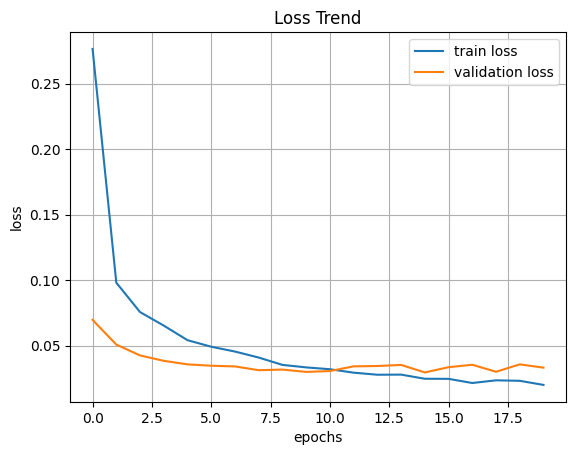

In [13]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')

plt.legend()

plt.show()

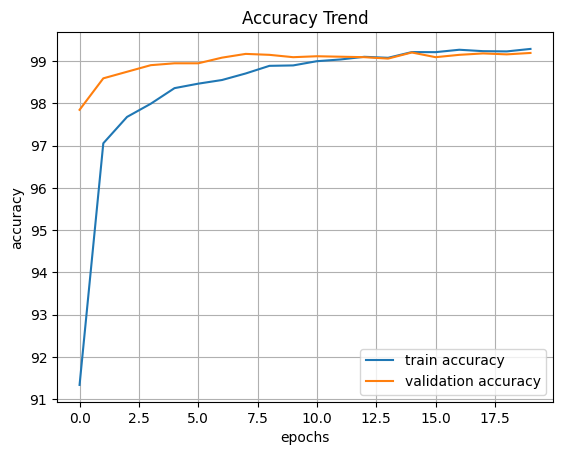

In [14]:
import matplotlib.pyplot as plt

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')

plt.legend()

plt.show()

이미지 데이터는 3차원 텐서

높이는 이미지, 세로, 방향, 픽셀 수, 너비는 이미지의 가로 방향 픽셀 수, 채널은 개별적인 데이터라고 말하는 것이 정확(example 흑백 1개, 컬러 3개-영상처리에서 배운 내용)


컨볼루션을 하기 위해선 컨볼루션 공식에 따라 입력채널만큼 필터의 개수가 필요함.


=> 1개의 필터는 입력채널 개수와 일치하도록 확장되고 확장된 각각의 필터는 대응되는 입력채널에 컨볼루션 연산을 수정하여 특징맵(임시) 생성한 후에 이렇게 생성된 각각의 임시 특징맵을 모두 더하면 1개의 출력채널이 생성.